In [1]:
import time
import numpy as np
import matplotlib.pylab as plt
import emcee
from getdist import plots, MCSamples
import getdist
import scipy.stats as ss
import pandas as pd

import numpyro
import jax
import jax.numpy as jnp
import numpyro.distributions as dist
from numpyro.infer import MCMC, HMC, NUTS, init_to_value
from numpyro.handlers import seed
from numpyro.distributions import constraints
from numpyro.diagnostics import summary
from jax import grad, jit, vmap, jacfwd, jacrev
from utils.helpers import dill_save, dill_load
import random 

plt.rc("text", usetex=True)
plt.rc("font", **{"family": "sans-serif", "serif": ["Palatino"]})
figSize = (12, 8)
fontSize = 15

settings = {
    "mult_bias_correction_order": 0,
    "smooth_scale_2D": 0.3,
    "smooth_scale_1D": 0.3,
}
color1 = "#50C878"
color2 = "tomato"
color3 = "#222E50"
alpha = 0.9
palefactor = 0.9
linewidth = 2
contours = [0.68, 0.95]

In [5]:
# EMCEE 
DISCARD = 100
NSAMPLES = 2000 

# NUTS 
TREE_DEPTH = 8
EPS = 0.01
NSAMPLES_NUTS = 15000
WARMUP = 500

# General setup 
fiducial = np.ones(2)
normal_prior = ss.norm(0, 1)

In [6]:
def rosenbrock(xvalues):
    x_i_plus_one = xvalues[1::2]
    x_i = xvalues[0::2]
    term_1 = 9.0 * (x_i_plus_one - x_i**2) ** 2
    term_2 = (x_i - 1) ** 2
    return sum(term_1 + term_2)


def loglikelihood(xvalues):
    return -rosenbrock(xvalues)


@jax.jit
def jit_loglike(xvalues):
    return loglikelihood(xvalues)


@jax.jit
def jit_grad_loglike(xvalues):
    return jax.jacfwd(loglikelihood)(xvalues)


def logposterior(xvalues):
    # logprior = sum([uniform_prior.logpdf(xvalues[i]) for i in range(ndim)])
    logprior = sum([normal_prior.logpdf(xvalues[i]) for i in range(len(xvalues))])
    if np.isfinite(logprior):
        return logprior + jit_loglike(xvalues)
    return -1e32


# $\frac{\tau[\nabla \mathcal{L}]}{\tau[\mathcal{L}]}$

In [7]:
%%timeit
jit_loglike(fiducial)

37.7 µs ± 2.88 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [8]:
%%timeit
jit_loglike(fiducial)

41.3 µs ± 6.17 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [9]:
%%timeit
jit_grad_loglike(fiducial)

35.9 µs ± 1.52 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [10]:
%%timeit
jit_grad_loglike(fiducial)

38.2 µs ± 2.92 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [11]:
dimensions = np.arange(1, 6, 1, dtype=int) * 20
nrepeat = 10

tau_like = []
tau_gradlike = []

for repeat in range(nrepeat):
    record_tau_like = []
    record_tau_grad_like = []

    for d in dimensions:
        testpoint = jnp.ones(d) + 1e-2

        start_time = time.time()
        loglike = jit_loglike(testpoint)
        time_taken = time.time() - start_time
        record_tau_like.append(time_taken)

        start_time = time.time()
        grad_loglike = jit_grad_loglike(testpoint)
        time_taken = time.time() - start_time
        record_tau_grad_like.append(time_taken)

    record_tau_like = np.asarray(record_tau_like)
    record_tau_grad_like = np.asarray(record_tau_grad_like)
    tau_like.append(record_tau_like)
    tau_gradlike.append(record_tau_grad_like)

tau_like = np.asarray(tau_like)
tau_gradlike = np.asarray(tau_gradlike)

In [12]:
time_ratio = np.mean(tau_gradlike / tau_like, axis=0)
time_ratio_error = np.std(tau_gradlike / tau_like, axis=0)

In [13]:
# dill_save(time_ratio, 'rosenbrock', 'gL_L_time_ratio')
# dill_save(time_ratio_error, 'rosenbrock', 'gL_L_time_ratio_error')

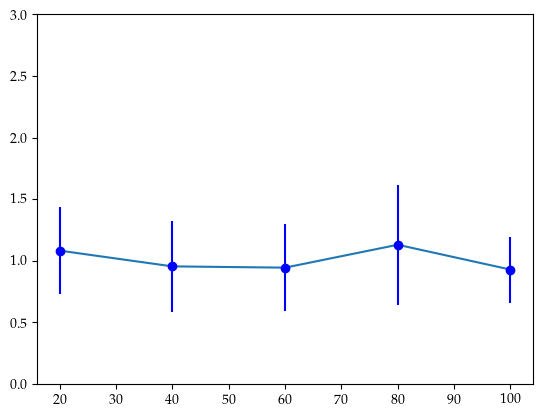

In [14]:
plt.plot(dimensions, time_ratio)
plt.errorbar(dimensions, time_ratio, yerr=time_ratio_error, fmt="bo")
plt.ylim(0, 3)
plt.show()

## EMCEE

In [15]:
def calculate_summary(samples_1, samples_2, thin=None, ndecimal=3):
    record = []
    for i in range(samples_1.shape[1]):
        if thin is not None:
            x1 = samples_1[:,i][0::thin]
            x2 = samples_2[:,i][0::thin]
        else:
            x1 = samples_1[:,i]
            x2 = samples_2[:,i]
        nsamples = x1.shape[0] + x2.shape[0]
        
        testsamples = np.vstack(([x1, x2]))
        summary_stats = summary(testsamples)
        summary_stats[f"p_{i}"] = summary_stats.pop("Param:0")
        record.append(summary_stats)

    record_df = []
    for i in range(len(record)):
        record_df.append(
            pd.DataFrame(record[i])
            .round(ndecimal)
            .loc[["r_hat", "n_eff", "mean", "std"]]
        )
    
    print(f'Total number of samples after thinning is {nsamples}')
    record_df = pd.concat(record_df, axis=1).T
    record_df["n_eff"] /= nsamples
    return record_df

def single_emcee_run(fiducial, ndim):
    pos = fiducial + 1e-3 * np.random.randn(2 * ndim, ndim)
    nwalkers, ndim = pos.shape
    sampler = emcee.EnsembleSampler(nwalkers, ndim, logposterior)
    sampler.run_mcmc(pos, NSAMPLES, progress=True)
    return sampler


def run_emcee(fiducial, ndim):

    record_samples = []
    for chain in range(2):
        sampler = single_emcee_run(fiducial, ndim)
        emcee_samples = sampler.get_chain(discard=DISCARD, flat=True)
        record_samples.append(emcee_samples)
    return record_samples

## NUTS

In [16]:
def model(ndim):
    xvalues = jnp.zeros(ndim)
    for i in range(ndim):
        y = numpyro.sample(f"x{i}", dist.Normal(0, 1))
        xvalues = xvalues.at[i].set(y)
    numpyro.factor("log_prob", jit_loglike(xvalues))

In [17]:
def run_nuts(initial, ndim):
    init_strategy = init_to_value(values={f"x{i}": initial[i] for i in range(ndim)})
    nuts_kernel = NUTS(
        model,
        step_size=EPS,
        dense_mass=True,
        max_tree_depth=TREE_DEPTH,
        init_strategy=init_strategy,
    )
    mcmc = MCMC(
        nuts_kernel,
        num_chains=2,
        num_warmup=WARMUP,
        num_samples=NSAMPLES_NUTS,
        chain_method="vectorized",
    )
    random_integer = random.randint(0, 1000)
    mcmc.run(
        jax.random.PRNGKey(random_integer),
        ndim=ndim,
        extra_fields=("potential_energy", "num_steps", "accept_prob"),
    )
    nsteps = mcmc.get_extra_fields(group_by_chain=False)['num_steps'].sum().item()
    return mcmc, nsteps

In [18]:
def process_nuts_chains(mcmc, ndim):
    chains = mcmc.get_samples(group_by_chain=True)
    record = []
    for c in range(2):
        samples = np.vstack([np.asarray(chains[f"x{i}"][c]) for i in range(ndim)]).T
        record.append(samples)
    return record

In [19]:
def calculate_metrics(samples_1, samples_2, thin):
    
    results = calculate_summary(samples_1, samples_2, thin = thin)
    mean_neff = results['n_eff'].mean()
    
    # distance calculations 
    ndimensions = samples_1.shape[1]
    reference = pd.DataFrame([[0.45, 0.45], [0.39, 0.48]] * int(ndimensions / 2), columns=["mean", "std"])
    reference.index = [f"p_{i}" for i in range(ndimensions)]
    difference_mean = np.abs(results["mean"] - reference["mean"])
    difference_std = np.abs(results["std"] - reference["std"])
    
    mean_mean = np.mean(difference_mean)
    mean_std = np.mean(difference_std)
    return {'mean_neff': mean_neff, 'mean_mean': mean_mean, 'mean_std': mean_std}

In [20]:
def run_experiment(ndim, thin = 10):
    initial = [0.45, 0.39] * int(ndim/2)
    emcee_samples = run_emcee(initial, ndim)
    
    mcmc_nuts, nsteps = run_nuts(initial, ndim)
    nuts_samples = process_nuts_chains(mcmc_nuts, ndim)
    
    emcee_metrics = calculate_metrics(emcee_samples[0], emcee_samples[1], thin = thin)
    nuts_metrics = calculate_metrics(nuts_samples[0], nuts_samples[1], thin = thin)
    
    return emcee_samples, emcee_metrics, nuts_samples, nuts_metrics

# Single Experiment

In [ ]:
emcee_samples, emcee_metrics, nuts_samples, nuts_metrics = run_experiment(ndim = 10, thin = 10)

In [ ]:
emcee_metrics

In [ ]:
nuts_metrics

## Plots

In [ ]:
emcee_samples_flat = np.concatenate(emcee_samples)
nuts_samples_flat = np.concatenate(nuts_grouped)

In [ ]:
ndimplot = 6
names = ["x%s" % i for i in range(ndimplot)]
labels = [f"$x_{i}$" for i in range(ndimplot)]
samples_emcee = MCSamples(
    samples=emcee_samples_flat[:, 0:ndimplot], names=names, labels=labels
)
samples_nuts = MCSamples(
    samples=nuts_samples_flat[:, 0:ndimplot], names=names, labels=labels
)

In [ ]:
G = plots.getSubplotPlotter(subplot_size=1)
G.settings.solid_contour_palefactor = palefactor
G.settings.alpha_filled_add = alpha
G.settings.num_plot_contours = 2
G.settings.lw_contour = 2
G.settings.axes_fontsize = 20
G.settings.lab_fontsize = 20
G.settings.fontsize = 15  # important for padding in x-axis
G.settings.line_styles = "Accent"
G.settings.legend_fontsize = 20
G.triangle_plot(
    [samples_emcee, samples_nuts],
    filled=[True, False],
    contour_colors=[color1, color3],
    contour_lws=2,
    legend_labels=["EMCEE", "NUTS"],
)
# plt.savefig('plots/rosenbrock.pdf', bbox_inches = 'tight')
plt.show()

# Many Dimensions

In [21]:
dimensions = np.arange(1, 11, 1) * 10
record_emcee_metrics = []
record_nuts_metrics = [] 

for ndim in dimensions:
    emcee_samples, emcee_metrics, nuts_samples, nuts_metrics = run_experiment(ndim = ndim, thin = 10)
    record_emcee_metrics.append(emcee_metrics)
    record_nuts_metrics.append(nuts_metrics)

sample: 100%|████████████████████████████████████████████████████████████████████████| 15500/15500 [01:56<00:00, 132.83it/s]


Total number of samples after thinning is 7600
Total number of samples after thinning is 3000


sample: 100%|█████████████████████████████████████████████████████████████████████████| 15500/15500 [03:36<00:00, 71.58it/s]


Total number of samples after thinning is 15200
Total number of samples after thinning is 3000


sample: 100%|█████████████████████████████████████████████████████████████████████████| 15500/15500 [05:25<00:00, 47.61it/s]


Total number of samples after thinning is 22800
Total number of samples after thinning is 3000


sample: 100%|█████████████████████████████████████████████████████████████████████████| 15500/15500 [06:05<00:00, 42.44it/s]


Total number of samples after thinning is 30400
Total number of samples after thinning is 3000


sample: 100%|█████████████████████████████████████████████████████████████████████████| 15500/15500 [06:07<00:00, 42.12it/s]


Total number of samples after thinning is 38000
Total number of samples after thinning is 3000


sample: 100%|█████████████████████████████████████████████████████████████████████████| 15500/15500 [06:37<00:00, 38.99it/s]


Total number of samples after thinning is 45600
Total number of samples after thinning is 3000


sample: 100%|█████████████████████████████████████████████████████████████████████████| 15500/15500 [07:28<00:00, 34.57it/s]


Total number of samples after thinning is 53200
Total number of samples after thinning is 3000


sample: 100%|█████████████████████████████████████████████████████████████████████████| 15500/15500 [09:19<00:00, 27.70it/s]


Total number of samples after thinning is 60800
Total number of samples after thinning is 3000


sample: 100%|█████████████████████████████████████████████████████████████████████████| 15500/15500 [11:20<00:00, 22.78it/s]


Total number of samples after thinning is 68400
Total number of samples after thinning is 3000


sample: 100%|█████████████████████████████████████████████████████████████████████████| 15500/15500 [13:03<00:00, 19.79it/s]


Total number of samples after thinning is 76000
Total number of samples after thinning is 3000


In [22]:
df_emcee_metrics = pd.DataFrame(record_emcee_metrics)
df_nuts_metrics = pd.DataFrame(record_nuts_metrics)

In [23]:
df_emcee_metrics.index = dimensions
df_nuts_metrics.index = dimensions

In [24]:
df_emcee_metrics.to_csv('rosenbrock/emcee_metrics.csv')
df_nuts_metrics.to_csv('rosenbrock/nuts_metrics.csv')

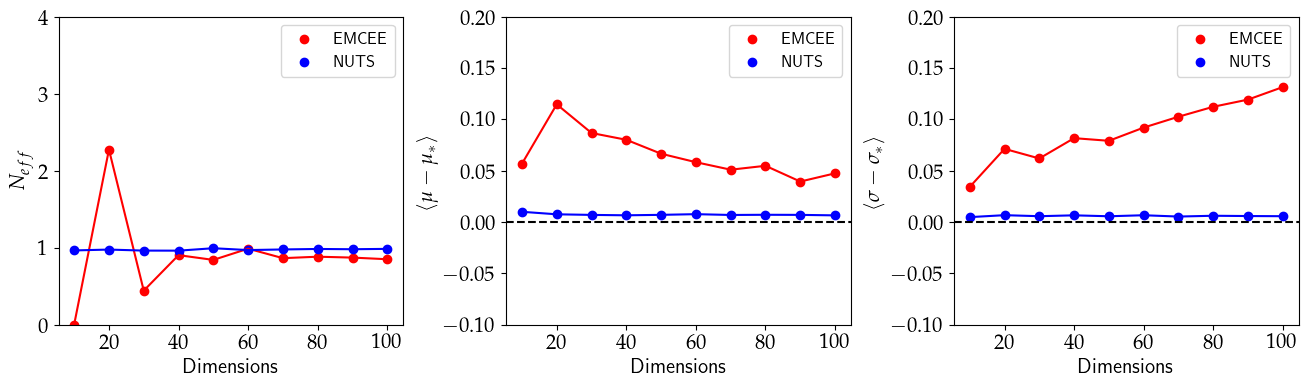

In [26]:
plt.figure(figsize = (16, 4))
plt.subplot(131)
plt.scatter(dimensions, df_emcee_metrics['mean_neff'], c = 'r', label = 'EMCEE')
plt.plot(dimensions, df_emcee_metrics['mean_neff'], c = 'r')
plt.scatter(dimensions, df_nuts_metrics['mean_neff'], c = 'b', label = 'NUTS')
plt.plot(dimensions, df_nuts_metrics['mean_neff'], c = 'b')
plt.ylabel(r'$N_{eff}$', fontsize = fontSize)
plt.xlabel(r'Dimensions', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.ylim(0.0, 4.0)
plt.legend(loc='best',prop={'family':'sans-serif', 'size':12})

plt.subplot(132)
plt.axhline(0.0, linestyle ='--', c = 'k')
plt.scatter(dimensions, df_emcee_metrics['mean_mean'], c = 'r', label = 'EMCEE')
plt.plot(dimensions, df_emcee_metrics['mean_mean'], c = 'r')
plt.scatter(dimensions, df_nuts_metrics['mean_mean'], c = 'b', label = 'NUTS')
plt.plot(dimensions, df_nuts_metrics['mean_mean'], c = 'b')
plt.ylabel(r'$\langle \mu - \mu_{*}\rangle$', fontsize = fontSize)
plt.xlabel(r'Dimensions', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.ylim(-0.1, 0.2)
plt.legend(loc='best',prop={'family':'sans-serif', 'size':12})

plt.subplot(133)
plt.axhline(0.0, linestyle ='--', c = 'k')
plt.scatter(dimensions, df_emcee_metrics['mean_std'], c = 'r', label = 'EMCEE')
plt.plot(dimensions, df_emcee_metrics['mean_std'], c = 'r')
plt.scatter(dimensions, df_nuts_metrics['mean_std'], c = 'b', label = 'NUTS')
plt.plot(dimensions, df_nuts_metrics['mean_std'], c = 'b')
plt.ylabel(r'$\langle \sigma - \sigma_{*}\rangle$', fontsize = fontSize)
plt.xlabel(r'Dimensions', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.ylim(-0.1, 0.2)
plt.legend(loc='best',prop={'family':'sans-serif', 'size':12})
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None)
plt.show()